In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from keras.preprocessing import image

### Data Extraction

In [115]:
p = Path("Images")
dirs = p.glob("*")
x = []
y = []
label = {}
cnt = 0;
for folder in dirs:
    cur_label = str(folder).split("\\")[-1][:-1]
    label[cur_label] = cnt
    for img in folder.glob("*.jpg"):
        cur_img = image.load_img(img, target_size=(30, 30))
        cur_img = image.img_to_array(cur_img)
        x.append(cur_img)
        y.append(cnt)
    cnt += 1

In [116]:
# converting to numpy array
x = np.array(x, dtype = 'float32')/255.0
y = np.array(y)
print(x.shape, y.shape)

(808, 30, 30, 3) (808,)


In [117]:
# flattenig the images into individual pixels
x = x.reshape((x.shape[0], -1))
print(x.shape, y.shape)

(808, 2700) (808,)


In [25]:
# randomizing the data
combined = list(zip(x, y))
random.shuffle(combined)
x[:], y[:] = zip(*combined)

### Building The Classifier
- Till now we have an x array with some training data
- and on y whe have corresponding labels for this data
- we have one dictionary "labels" which map corresponding y to its respective classname
- now we have to build classifier 

In [27]:
# Step1: splitting the data into their respective classes
classes = len(np.unique(y))
data = {}
for i in range(classes):
    data[i] = []
for i in range(x.shape[0]):
    data[y[i]].append(x[i])
for i in range(classes):
    data[i] = np.array(data[i])

In [30]:
# now we have seperated the data into their respective classes
for j in range(classes):
    print(data[i].shape)

(202, 2700)
(202, 2700)
(202, 2700)
(202, 2700)


In [47]:
# Step2: building our svm model
class SVM:
    def __init__(self, c = 1.0):
        self.c = c
    def hingeloss(self, x, y):
        loss = 0.5*np.dot(self.w, self.w.T)
        for i in range(x.shape[0]):
            ti = y[i]*(np.dot(x[i], self.w.T) + self.b)
            loss += self.c*max(0, 1 - ti)
        return loss[0][0]
    # n = learning_rate
    # itr = no of iterations we want to do
    # batch = batch size
    def fit(self, x, y, b_sz, n, itr):
        self.w = np.zeros((1, x.shape[1]))
        self.b = 0
        self.l = [] # loss change as we progress our descent
        for i in range(itr):
            ids = np.arange(x.shape[0])
            np.random.shuffle(ids)
            for batch in range(0, x.shape[0], b_sz):
                gradw = np.zeros((1, x.shape[1]))
                gradb = 0
                for k in range(batch, batch + b_sz):
                    if k >= x.shape[0]:
                        break
                    curr = ids[k]
                    ti = y[curr]*(np.dot(x[curr], self.w.T) + self.b)
                    if ti <= 1:
                        gradw += self.c*y[curr]*x[curr]
                        gradb += self.c*y[curr]
                self.w = self.w - n*self.w + n*gradw
                self.b = self.b - n*self.b + n*gradb
            self.l.append(self.hingeloss(x, y))

In [49]:
# Step3 building (classes)C(2) classifiers one for each possible pair
def combine_data(d1, d2): # combining data for chosen pair to train in svm model
    l1, l2 = d1.shape[0], d2.shape[0]
    f = d1.shape[1]
    dx = np.zeros((l1 + l2, f))
    dy = np.zeros((l1 + l2, ))
    dx[:l1] = d1
    dx[l1:] = d2
    dy[:l1] = -1
    dy[l1:] = 1
    return dx, dy

[[-0.00099031  0.0141501   0.00768251 ... -0.04389376 -0.02882522
  -0.03430707]] -0.025830391277182178


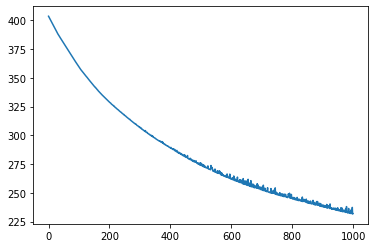

[[ 0.00882171  0.02806035  0.03065635 ...  0.00683761  0.00911432
  -0.00791903]] -0.12339219212054922


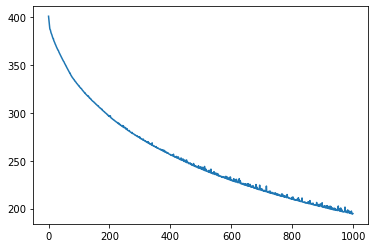

[[0.04243794 0.05247805 0.04966636 ... 0.02108973 0.02432162 0.01964386]] -0.03552955899111602


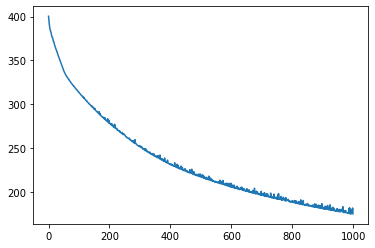

[[0.01205839 0.01402605 0.02375359 ... 0.03460551 0.02881268 0.02236644]] -0.09256309641159494


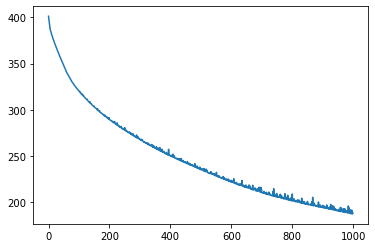

[[0.04267281 0.03902474 0.03935431 ... 0.04746832 0.04760574 0.03984319]] -0.010881800725002973


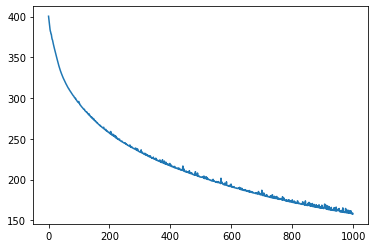

[[0.03374677 0.0271306  0.02578825 ... 0.02069316 0.02817638 0.02932251]] 0.07450457525542173


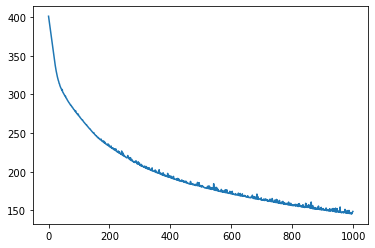

In [61]:
# training our (classes)C(2) classifiers
mysvm = SVM()
def train(data, classes):
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i] = {}
        for j in range(i + 1, classes):
            dx, dt = combine_data(data[i], data[j])
            mysvm.fit(dx, dt, 100, 0.00001, 1000)
            print(mysvm.w, mysvm.b)
            svm_classifiers[i][j] = (mysvm.w, mysvm.b)
            plt.plot(mysvm.l)  # plotting loss function for each classifier
            plt.show()
    return svm_classifiers
svm_classifier = train(data, classes)

In [69]:
# Step4: testing the accuracy of our trained model
def prediction(x):
    freq = np.zeros(classes)
    for i in range(classes):
        for j in range(i + 1, classes):
            (w, b) = svm_classifier[i][j]
            p = np.dot(x, w.T) + b
            if p >= 0 :
                freq[j] += 1
            else :
                freq[i] += 1
    return np.argmax(freq)
def accuracy(x):
    cnt = 0
    for i in range(x.shape[0]):
        if prediction(x[i]) == y[i]:
            cnt += 1
    return cnt/x.shape[0]

In [72]:
print(accuracy(x)*100)

60.76732673267327


### Classification using SK Learn

In [82]:
import multiprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [110]:
params = [
    {
        'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
        'C' : [0.1, 0.2, 0.4, 0.5, 1.0, 2.0, 5.0]
    }
]

In [111]:
svc = svm.SVC()
gs = GridSearchCV(estimator = svc, param_grid = params, n_jobs= -1)

In [118]:
gs.fit(x, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.1, 0.2, 0.4, 0.5, 1.0, 2.0, 5.0],
                          'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [124]:
print(100*gs.score(x, y))
print(gs.best_params_)

99.87623762376238
{'C': 5.0, 'kernel': 'rbf'}
